In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
seaborn.set()

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/whackawaldo/boglehead/main/backtest.csv', index_col=0)

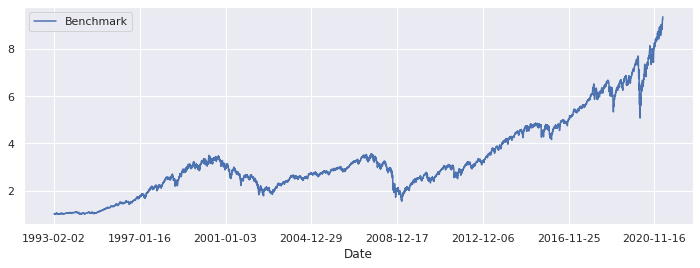

In [3]:
# Use SPY as the benchmark
records = []
for date, value in df['SPY'].dropna().iteritems():
  curr = records[-1]['Benchmark'] if len(records) > 0 else 1
  records.append({'Date': date, 'Benchmark': curr * (1 + value)})
B = pd.DataFrame(records).set_index('Date')
B.plot(figsize=(12,4));

### Plot Estimated TMF and UPRO Returns

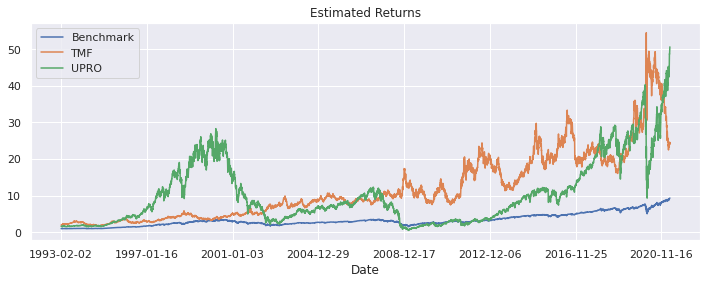

In [4]:
# Use UPRO and TMF, backfill using UPROSIM and LTTSIM
df['TMF'] = df['TMF'].fillna(df['LTTSIM'])
df['UPRO'] = df['UPRO'].fillna(df['UPROSIM'])

records = []
vals = {'TMF': 1, 'UPRO': 1}
for date, row in df[vals.keys()].dropna().iterrows():
  for asset, curr in vals.items():
    vals[asset] = curr * (1 + row[asset])
  records.append({'Date': date, **vals})

title = 'Estimated Returns'
X = pd.DataFrame(records).set_index('Date')
B.join(X).plot(title=title, figsize=(12, 4));

In [5]:
TARGET_ALLOCATIONS = [
  {'UPRO': .7, 'TMF': .3},               
  {'UPRO': .6, 'TMF': .4},               
  {'UPRO': .5, 'TMF': .5},               
  {'UPRO': .4, 'TMF': .6},               
  {'UPRO': .3, 'TMF': .7},               
]

In [6]:
percent_float = lambda x: f'{x * 100:.2f}%'
percent_label = lambda x: f'{int(x * 100):d}%'


def plot_portfolio(X, target_allocation, display_returns = True):
  X = X.reset_index().sort_values('Date')[['Date', 'Benchmark', 'Portfolio']]
  assert X.Portfolio.dropna().min() > 0

  allocs = target_allocation.items()
  title = ', '.join([f'{percent_label(v)} {k}' for k, v in allocs])

  # Compute the rolling n-year returns average
  if display_returns:
    for window in (1, 5, 10):
      rolling_returns = []
      # 252 trading days per year * number of years
      for chunk in X.rolling(252 * window):

        # Ensure we only look at complete subsets
        if len(chunk) != 252 * window: continue

        # Compute the growth relative to the first date in the window
        date = chunk.iloc[0]['Date']
        values = chunk['Portfolio']
        rolling_returns.append({'Date': date, 'Return': values.iloc[-1] / values.iloc[0] - 1})

      rr = pd.DataFrame(rolling_returns).set_index('Date')["Return"]
      tmin, tmax, tmean = list(map(percent_label, [rr.min(), rr.max(), rr.mean()]))
      title += f'\n{window}-Year Returns Min: {tmin}, Max: {tmax}, Mean: {tmean}'
      print(f'Worst case scenario for {window}-year returns: {rr.idxmin()}', tmin)

  # Normalize the chart data
  X.Portfolio /= X.Portfolio.dropna().iloc[0]
  X.Benchmark /= X.Benchmark.dropna().iloc[0]

  plot_opts = dict(title=title, figsize=(12, 4))
  X.set_index('Date')[['Benchmark', 'Portfolio']].plot(**plot_opts)
  plt.show()

### Portfolio Rebalancing: None

Worst case scenario for 1-year returns: 2000-09-15 -68%
Worst case scenario for 5-year returns: 1999-07-16 -69%
Worst case scenario for 10-year returns: 2000-03-23 -80%


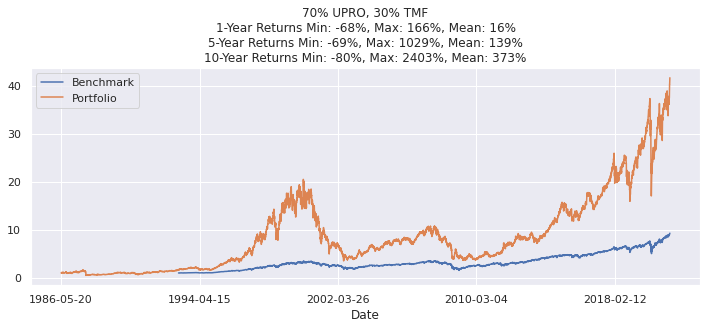

Worst case scenario for 1-year returns: 2000-09-15 -65%
Worst case scenario for 5-year returns: 1999-07-16 -63%
Worst case scenario for 10-year returns: 2000-03-23 -75%


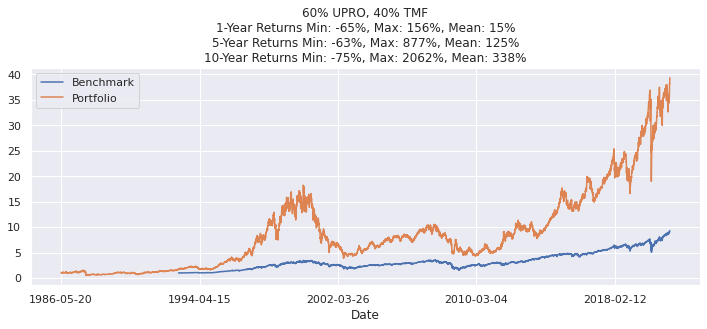

Worst case scenario for 1-year returns: 2000-09-15 -60%
Worst case scenario for 5-year returns: 1999-07-16 -57%
Worst case scenario for 10-year returns: 2000-03-23 -68%


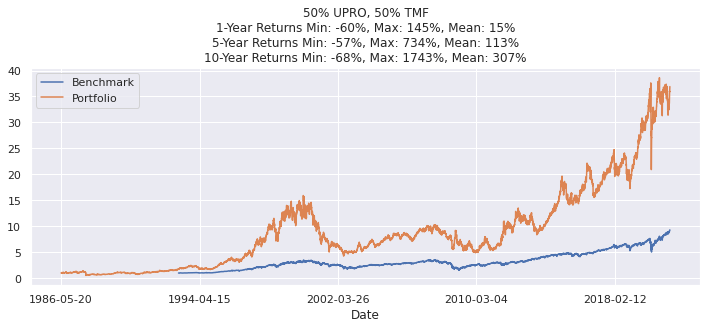

Worst case scenario for 1-year returns: 2000-09-15 -54%
Worst case scenario for 5-year returns: 1999-05-13 -48%
Worst case scenario for 10-year returns: 2000-03-23 -58%


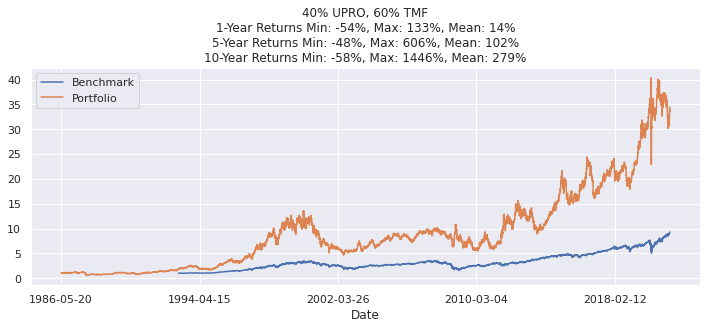

Worst case scenario for 1-year returns: 2008-12-30 -49%
Worst case scenario for 5-year returns: 1999-05-13 -36%
Worst case scenario for 10-year returns: 2000-03-23 -45%


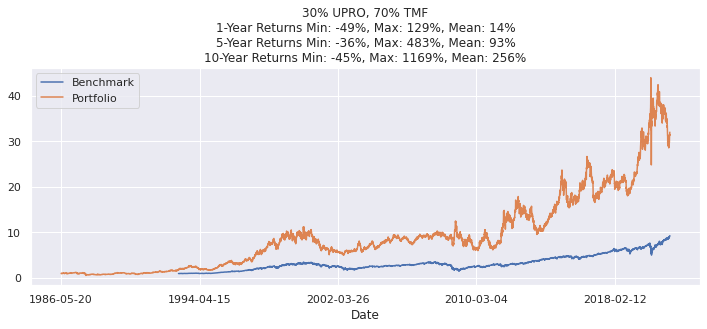

In [7]:
for target_allocation in TARGET_ALLOCATIONS:
  current_values = dict(target_allocation)

  records = []
  for date, row in df[target_allocation.keys()].dropna().iterrows():
    row = row.to_dict()
    for col in row.keys():
      current_values[col] *= 1 + row[col]
    total = sum(current_values.values())
    records.append(dict(current_values, Portfolio=total, Date=date))

  X = pd.DataFrame(records).set_index('Date').join(B)
  plot_portfolio(X, target_allocation)

### Portfolio Rebalancing: Yearly

In [8]:
def rebalance_portfolio(target_allocation, current_values):
  assert sum(target_allocation.values()) == 1
  total = sum(current_values.values())
  return {asset: total * target_allocation[asset] for asset in current_values.keys()}

Worst case scenario for 1-year returns: 1987-08-25 -66%
Worst case scenario for 5-year returns: 2004-03-08 -57%
Worst case scenario for 10-year returns: 1999-03-03 -60%


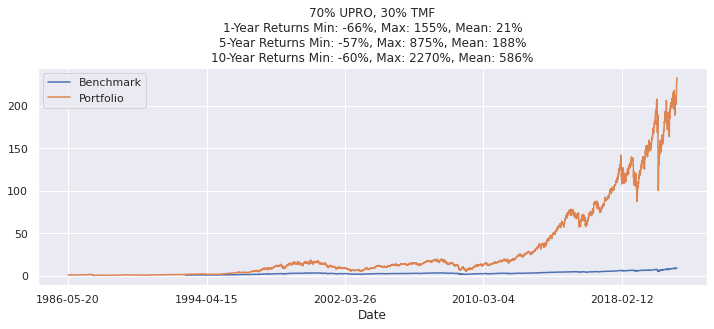

Worst case scenario for 1-year returns: 1987-08-25 -62%
Worst case scenario for 5-year returns: 2004-03-08 -44%
Worst case scenario for 10-year returns: 1999-02-24 -35%


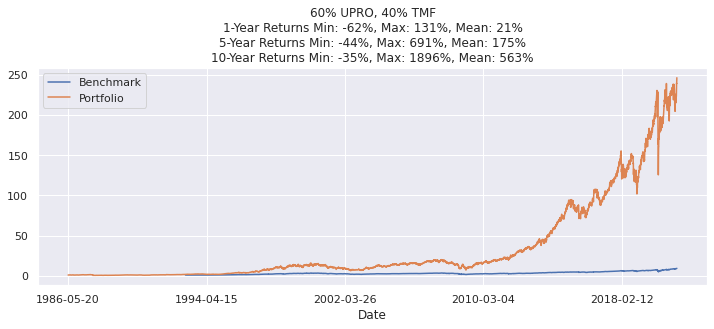

Worst case scenario for 1-year returns: 1987-08-25 -58%
Worst case scenario for 5-year returns: 2004-03-08 -30%
Worst case scenario for 10-year returns: 1999-02-23 -5%


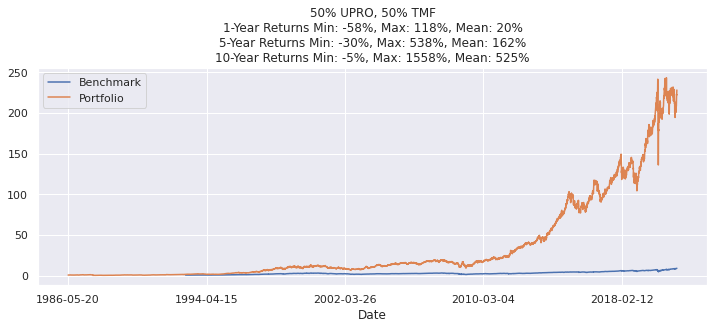

Worst case scenario for 1-year returns: 1987-08-25 -53%
Worst case scenario for 5-year returns: 2004-03-08 -15%
Worst case scenario for 10-year returns: 1999-02-23 28%


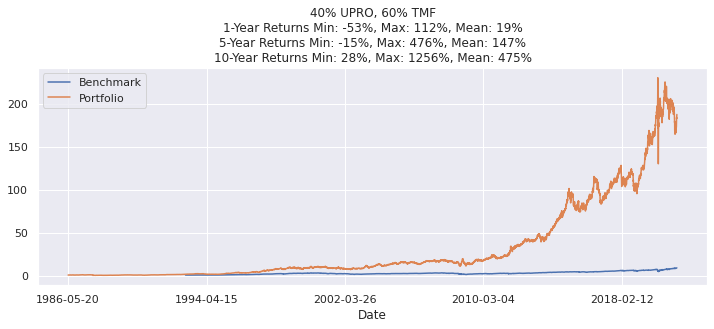

Worst case scenario for 1-year returns: 1987-08-25 -46%
Worst case scenario for 5-year returns: 2004-03-09 -1%
Worst case scenario for 10-year returns: 1998-10-27 58%


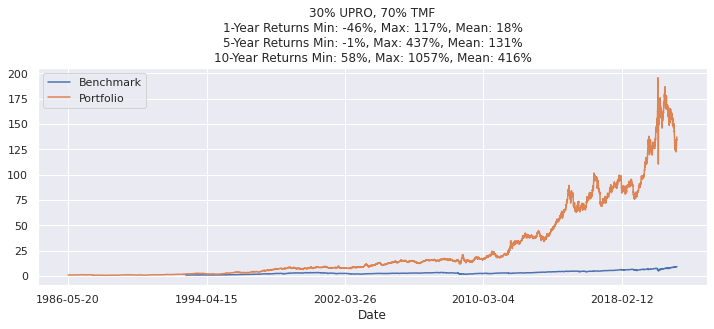

In [9]:
for target_allocation in TARGET_ALLOCATIONS:
  current_values = dict(target_allocation)

  records = []
  for date, row in df[target_allocation.keys()].dropna().iterrows():
    row = row.to_dict()

    # Should the portfolio be rebalanced?
    if len(records) > 0 and date[0:4] != records[-1]['Date'][0:4]:
      current_values = rebalance_portfolio(target_allocation, current_values)

    for col in row.keys():
      current_values[col] *= 1 + row[col]
    total = sum(current_values.values())
    records.append(dict(current_values, Portfolio=total, Date=date))

  X = pd.DataFrame(records).set_index('Date').join(B)
  # X = X[X.index >= '2010-02-01'].iloc[:10 * 252]
  plot_portfolio(X, target_allocation, display_returns=True)

### Portfolio Rebalancing: Quarterly

In [10]:
get_quarter = lambda date: 1 + (int(date[5:7]) - 1) // 3

Worst case scenario for 1-year returns: 2008-03-03 -73%
Worst case scenario for 5-year returns: 2004-03-08 -69%
Worst case scenario for 10-year returns: 1999-03-03 -74%


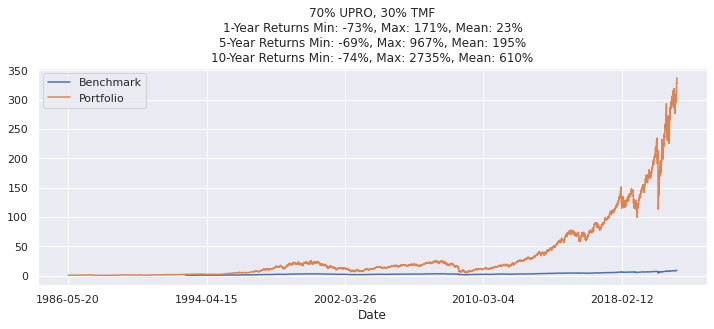

Worst case scenario for 1-year returns: 2008-03-03 -65%
Worst case scenario for 5-year returns: 2004-03-08 -59%
Worst case scenario for 10-year returns: 1999-02-24 -57%


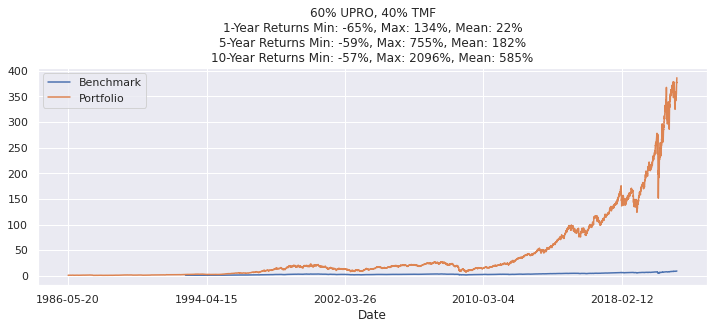

Worst case scenario for 1-year returns: 2007-10-29 -56%
Worst case scenario for 5-year returns: 2004-03-08 -46%
Worst case scenario for 10-year returns: 1999-02-23 -33%


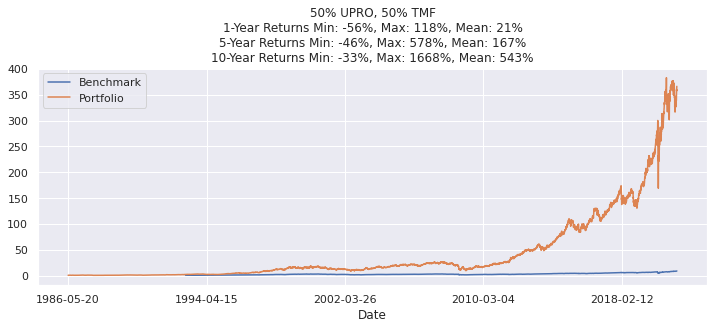

Worst case scenario for 1-year returns: 2007-10-29 -46%
Worst case scenario for 5-year returns: 2004-03-08 -31%
Worst case scenario for 10-year returns: 1999-02-23 -4%


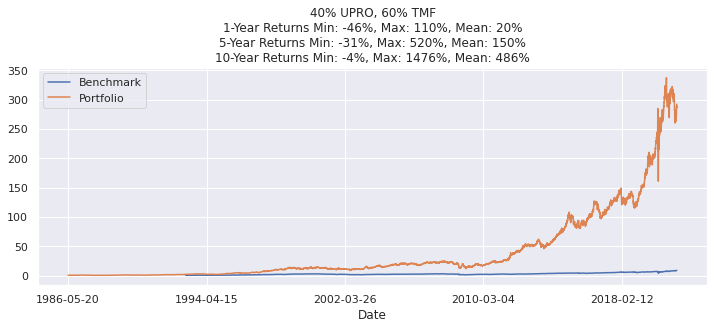

Worst case scenario for 1-year returns: 2007-11-02 -37%
Worst case scenario for 5-year returns: 2004-03-09 -15%
Worst case scenario for 10-year returns: 1999-02-23 31%


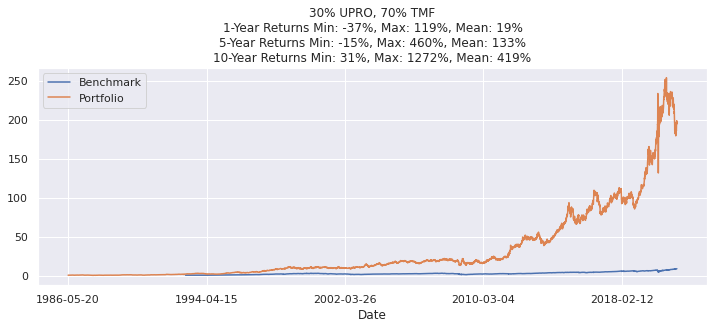

In [11]:
for target_allocation in TARGET_ALLOCATIONS:
  current_values = dict(target_allocation)

  records = []
  for date, row in df[target_allocation.keys()].dropna().iterrows():
    row = row.to_dict()
    quarter_curr = get_quarter(date)
    quarter_prev = get_quarter(records[-1]['Date']) if len(records) > 0 else None

    # Should the portfolio be rebalanced?
    if len(records) > 0 and quarter_curr != quarter_prev:
      current_values = rebalance_portfolio(target_allocation, current_values)

    for col in row.keys():
      current_values[col] *= 1 + row[col]
    total = sum(current_values.values())
    records.append(dict(current_values, Portfolio=total, Date=date))

  X = pd.DataFrame(records).set_index('Date').join(B)
  # X = X[X.index >= '2010-02-01'].iloc[:10 * 252]
  plot_portfolio(X, target_allocation, display_returns=True)

### Portfolio Rebalancing: Monthly

Worst case scenario for 1-year returns: 2008-03-04 -78%
Worst case scenario for 5-year returns: 2004-03-08 -75%
Worst case scenario for 10-year returns: 1999-03-03 -81%


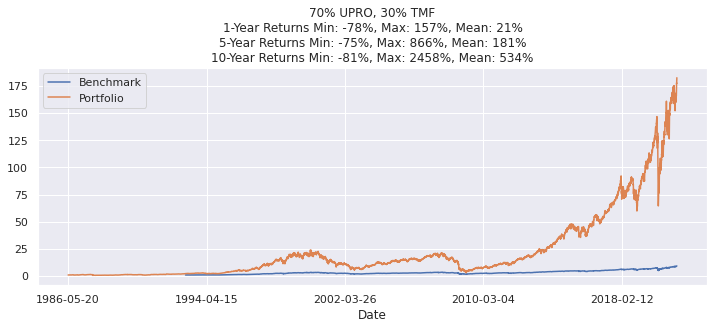

Worst case scenario for 1-year returns: 2008-03-03 -71%
Worst case scenario for 5-year returns: 2004-03-08 -66%
Worst case scenario for 10-year returns: 1999-03-03 -69%


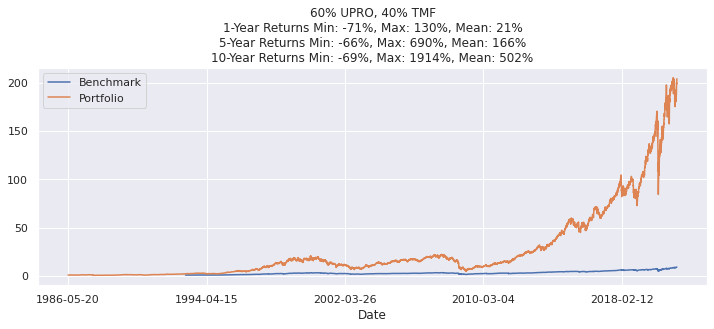

Worst case scenario for 1-year returns: 2008-03-03 -63%
Worst case scenario for 5-year returns: 2004-03-08 -55%
Worst case scenario for 10-year returns: 1999-02-24 -51%


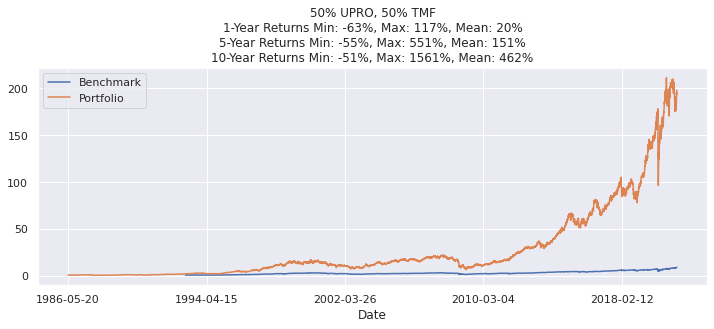

Worst case scenario for 1-year returns: 2008-03-03 -52%
Worst case scenario for 5-year returns: 2004-03-08 -42%
Worst case scenario for 10-year returns: 1999-02-23 -25%


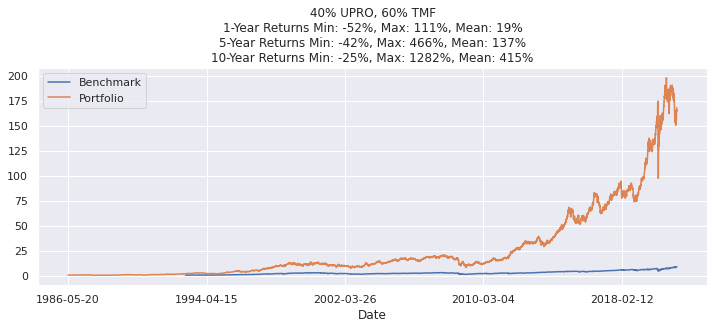

Worst case scenario for 1-year returns: 2008-03-03 -39%
Worst case scenario for 5-year returns: 2005-02-14 -26%
Worst case scenario for 10-year returns: 1999-02-23 8%


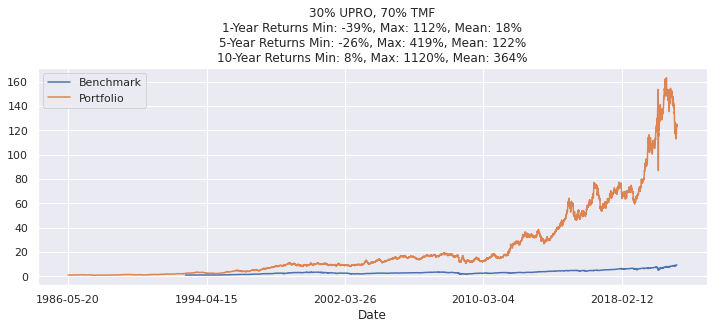

In [12]:
for target_allocation in TARGET_ALLOCATIONS:
  current_values = dict(target_allocation)

  records = []
  for date, row in df[target_allocation.keys()].dropna().iterrows():
    row = row.to_dict()

    # Should the portfolio be rebalanced?
    if len(records) > 0 and date[5:7] != records[-1]['Date'][5:7]:
      current_values = rebalance_portfolio(target_allocation, current_values)

    for col in row.keys():
      current_values[col] *= 1 + row[col]
    total = sum(current_values.values())
    records.append(dict(current_values, Portfolio=total, Date=date))

  X = pd.DataFrame(records).set_index('Date').join(B)
  # X = X[X.index >= '2010-02-01'].iloc[:10 * 252]
  plot_portfolio(X, target_allocation, display_returns=True)

### Portfolio Rebalancing: Daily

Worst case scenario for 1-year returns: 2008-03-04 -76%
Worst case scenario for 5-year returns: 2004-03-08 -71%
Worst case scenario for 10-year returns: 1999-03-03 -77%


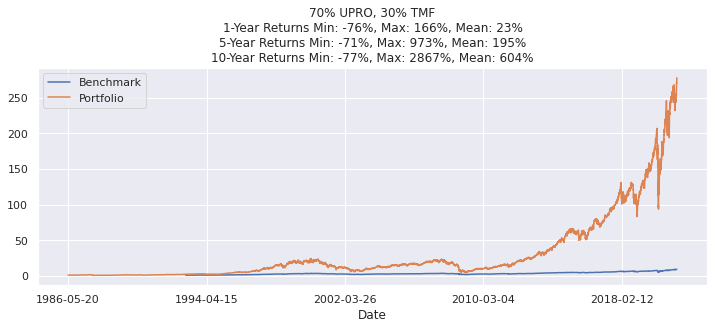

Worst case scenario for 1-year returns: 2008-03-03 -67%
Worst case scenario for 5-year returns: 2004-03-08 -60%
Worst case scenario for 10-year returns: 1999-03-03 -61%


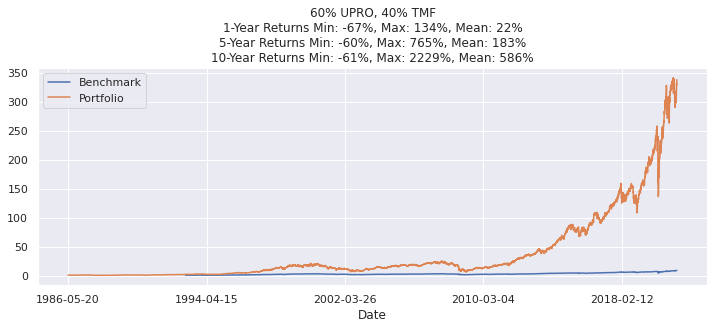

Worst case scenario for 1-year returns: 2007-11-23 -57%
Worst case scenario for 5-year returns: 2004-03-08 -46%
Worst case scenario for 10-year returns: 1999-02-24 -37%


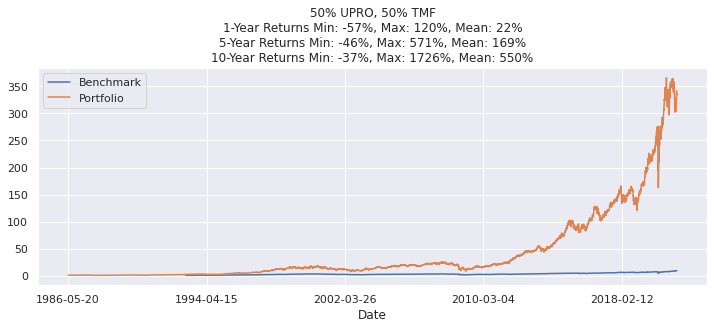

Worst case scenario for 1-year returns: 2007-10-29 -46%
Worst case scenario for 5-year returns: 2004-03-08 -30%
Worst case scenario for 10-year returns: 1999-02-23 -4%


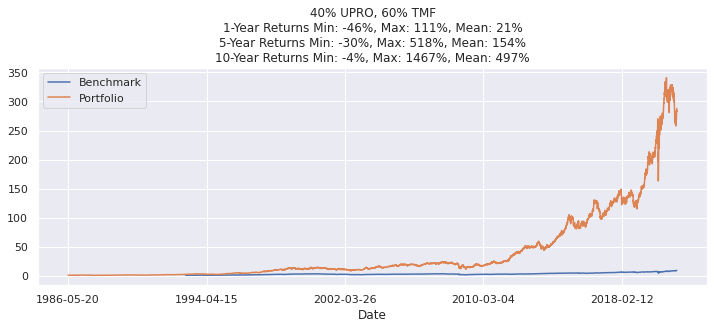

Worst case scenario for 1-year returns: 1986-10-21 -35%
Worst case scenario for 5-year returns: 2004-03-08 -12%
Worst case scenario for 10-year returns: 1999-02-23 35%


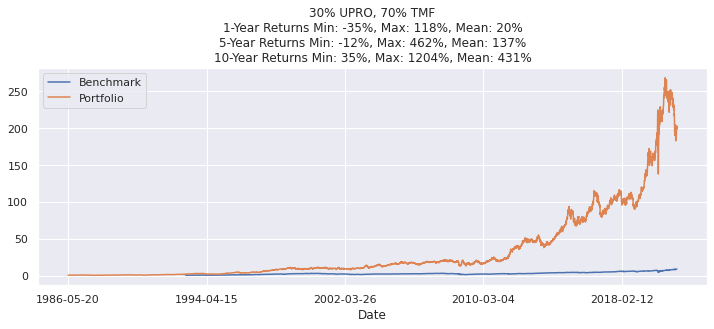

In [13]:
for target_allocation in TARGET_ALLOCATIONS:
  current_values = dict(target_allocation)

  records = []
  for date, row in df[target_allocation.keys()].dropna().iterrows():
    row = row.to_dict()

    # Should the portfolio be rebalanced?
    if len(records) > 0:
      current_values = rebalance_portfolio(target_allocation, current_values)

    for col in row.keys():
      current_values[col] *= 1 + row[col]
    total = sum(current_values.values())
    records.append(dict(current_values, Portfolio=total, Date=date))

  X = pd.DataFrame(records).set_index('Date').join(B)
  # X = X[X.index >= '2010-02-01'].iloc[:10 * 252]
  plot_portfolio(X, target_allocation, display_returns=True)

### Portfolio Rebalancing: Threshold

In [14]:
THRESHOLD = .05

def is_threshold_breached(target_allocation, current_values, threshold=THRESHOLD):
  total_assets = sum(current_values.values())
  for asset, amount in current_values.items():
    ratio = amount / total_assets
    target = target_allocation[asset]
    diff = abs(ratio - target) / target
    if abs(ratio - target) > threshold: return True
  return False

Worst case scenario for 1-year returns: 2007-11-23 -77%
Worst case scenario for 5-year returns: 2004-03-08 -73%
Worst case scenario for 10-year returns: 1999-03-03 -79%


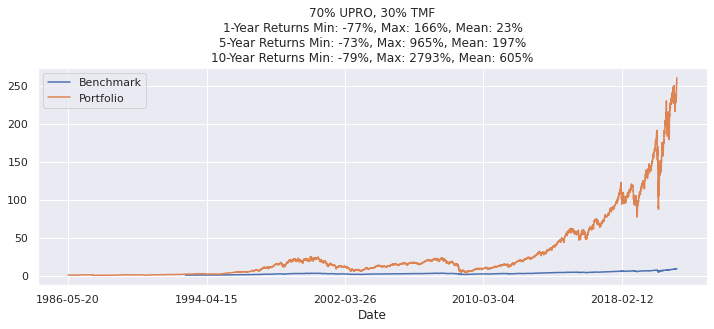

Worst case scenario for 1-year returns: 2007-11-23 -67%
Worst case scenario for 5-year returns: 2004-03-08 -60%
Worst case scenario for 10-year returns: 1999-03-03 -63%


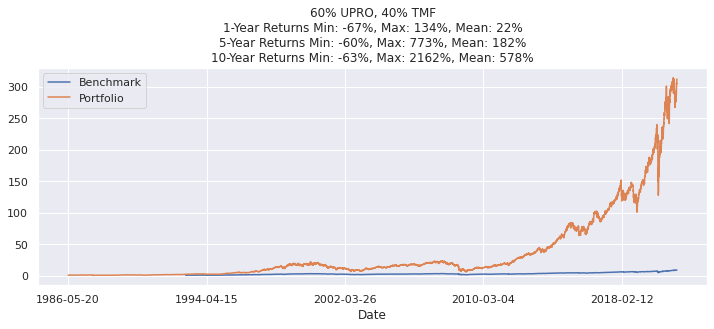

Worst case scenario for 1-year returns: 2008-03-03 -56%
Worst case scenario for 5-year returns: 2004-03-08 -47%
Worst case scenario for 10-year returns: 1999-02-24 -38%


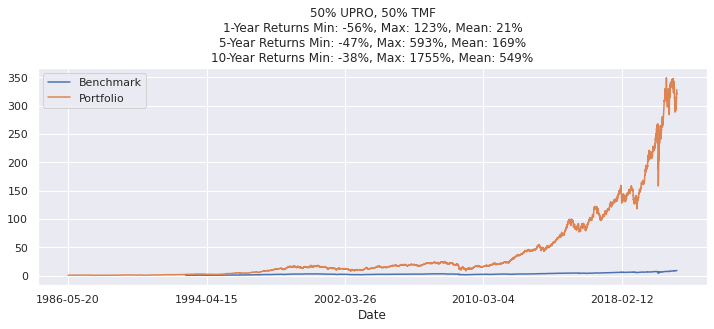

Worst case scenario for 1-year returns: 2007-10-29 -46%
Worst case scenario for 5-year returns: 2004-03-08 -31%
Worst case scenario for 10-year returns: 1999-02-23 -7%


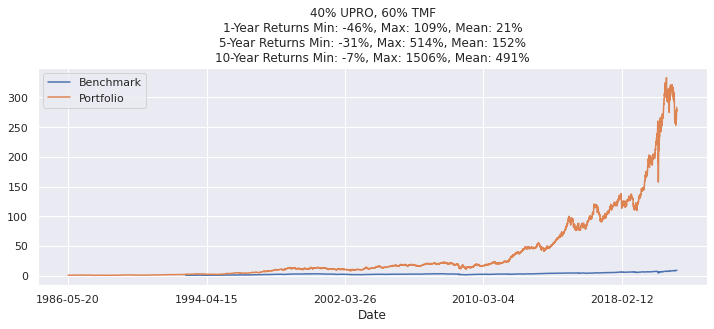

Worst case scenario for 1-year returns: 2007-10-29 -38%
Worst case scenario for 5-year returns: 2004-03-08 -16%
Worst case scenario for 10-year returns: 1999-02-23 24%


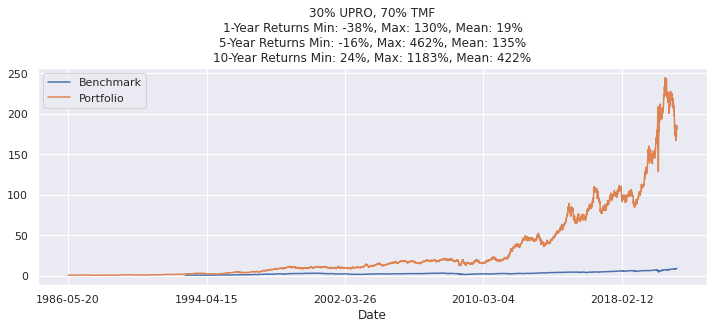

In [15]:
for target_allocation in TARGET_ALLOCATIONS:
  current_values = dict(target_allocation)

  records = []
  for date, row in df[target_allocation.keys()].dropna().iterrows():
    row = row.to_dict()

    # Should the portfolio be rebalanced?
    if len(records) > 100 and is_threshold_breached(target_allocation, current_values, THRESHOLD):
      current_values = rebalance_portfolio(target_allocation, current_values)

    for col in row.keys():
      current_values[col] *= 1 + row[col]
    total = sum(current_values.values())
    records.append(dict(current_values, Portfolio=total, Date=date))

  X = pd.DataFrame(records).set_index('Date').join(B)
  # X = X[X.index >= '2010-02-01'].iloc[:10 * 252]
  plot_portfolio(X, target_allocation, display_returns=True)